In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split

## 读取数据

In [3]:
train_df = pd.read_csv('../data/train.tsv', sep='\t')
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
X_data,y_data = train_df["Phrase"].values, train_df["Sentiment"].values

In [5]:
test = 5000
X_data=X_data[:test]
y_data=y_data[:test]

## 数据预处理
### 划分训练测试集

In [6]:
def data_len_sort(X,y):
    '''将训练集按照句子长度升序排序，避免每一个batch内句子长短不一，padding过度'''
    X = np.array(X).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    all_data = list(np.hstack((X,y)))
    all_data.sort(key=lambda x:len(x[0].split())) # 按照句子长度升序排序
    X_sort,y_sort = [item[0] for item in all_data],[item[1] for item in all_data]
    return X_sort,y_sort

def data_split_and_sort(X,y,test_size=0.2,sorted=True):
    '''划分数据集
    Parameters:
        X,y - data,label
        test_size - test data percentage
        sorted  - if sort data after split to avoid padding too much
    return:
        X_train, X_test, y_train, y_test
    '''
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=42, stratify=y)
    if sorted :
        X_train, y_train = data_len_sort(X_train,y_train)
        X_test, y_test = data_len_sort(X_test,y_test)
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = data_split_and_sort(X_data,y_data)

### 数据初始化 & 自定义dataloader

In [8]:
batch_size = 10

- 将数据库中的所有单词提取出来建立词表
- 句子转换为对应单词id所组成的序列（长度不同
- 序列作为模型输入，在数据加载阶段会进行padding以统一长度

In [9]:
from dataprocessing import Data_init,dataloader

#### 随机初始化
- 本阶段不需额外处理，在训练时直接随机初始化embedding
- 词向量会在训练时作为参数同步训练

In [10]:
data_init_random = Data_init(X_data)

#### [Glove](https://nlp.stanford.edu/projects/glove/)
- 提供了预训练好的词向量
- 需要把词向量对应到自定义的词表中,形成嵌入矩阵
- 数据中可能存在没有预训练词向量的单词，需要初始化为全0向量

In [11]:
with open('../data/glove.6B.50d.txt','rb') as f:  # for glove embedding
    lines=f.readlines()

In [12]:
lines[0].split()[0] #单词

b'the'

In [13]:
len(lines[0].split()[1:]) #词向量

50

In [14]:
glove_dict = {}
for line in lines:
    line = line.split()
    word = line[0].decode("utf-8").lower()
    word_vec = line[1:]
    glove_dict[word] =  list(map(float,word_vec))
len(glove_dict)

400000

eg:

我的数据初始化后的词表：

    { [word]:0,[love]:1,[world]:10,[hosipitality]:17 ...}

我需要获得的预训练embedding矩阵 (len(my_vocab) * d)：

    [
        0:[word vector of **we**]
        1:[word vector of **love**]
        ...
        10:[word vector of **world**]
        ...
        17:[ 0* dendimension of word vector](because don't have word vector of **hospitality**)
        ...
    ]

In [15]:
data_init = Data_init(X_data,trained_dict=glove_dict,trained_size=50)
glove_embed = data_init.get_embed_mat()

In [16]:
len(glove_embed)

1469

In [17]:
train_seq = data_init.get_id_seg(X_train) #使用预训练数据初始化不影响句子对应的单词序列的生成
test_seq = data_init.get_id_seg(X_test)
train_data = dataloader(train_seq,y_train,batch_size=batch_size)
test_data = dataloader(test_seq,y_test,batch_size=batch_size)

## 模型建立

In [18]:
import torch
import torch.nn.functional as F
from torch import optim

In [19]:
import model

### [CNN](https://arxiv.org/pdf/1408.5882.pdf)
    
- 使用4个不同的卷积层提取特征后分别池化，得到4*num_filters的特征
- 再经过一个全连接层对应到5个类别

CNN2和CNN1实现思路一致，仅代码风格不同，CNN2更简洁，可通过指定kernel_size调整卷积核大小和数目

In [20]:
#model_cnn = model.CNN_1(vocab_size=data_init.get_vocab_size(),embed_size=40,dropout_rate=0.4)
model_cnn = model.CNN_2(vocab_size=data_init.get_vocab_size(),embed_size=40,kernel_size=[2,3,4,5])

### RNN
- 取最后一个隐藏层hn作为输出，通过全连接层将其对应到5个类别 ([ref](https://blog.csdn.net/qq_42365109/article/details/115140450))
- 文档参考 [nn.RNN](https://blog.csdn.net/xu624735206/article/details/124017563)
  - * 要注意输入数据的格式，本代码是[batch_size,l_w]形式，必须使模型batch_first=True

In [21]:
# for RNN test
import torch
import torch.nn as nn
from torch import optim

In [22]:
vocab_size = 100
embed_size = 20
hidden_size = 10
num_layers = 1
num_class =5
x = nn.init.xavier_normal_(torch.Tensor(vocab_size, embed_size))
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size, _weight=x)
test_rnn = nn.RNN(input_size=embed_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)

In [23]:
fc = nn.Linear(hidden_size,num_class)
# x:[batch_size,num_words] -[10,7]
x = torch.zeros([15,7],dtype=torch.long)
#x:[batch_size,num_words,d]
x = embedding(x)
print('After embedding: x shape',x.shape)

After embedding: x shape torch.Size([15, 7, 20])


In [24]:
#output:[batch_size,num_words,l_h] ht:[1,batch_size,l_h]
output , hn =test_rnn(x)
print('Trough RNN output shape{} ,hn shape {}'.format(output.shape,hn.shape))
#out[1,batch_size,5] ->[batch_size,5]
out = fc(hn).squeeze(0)
print('Final: out shape',out.shape)


Trough RNN output shapetorch.Size([15, 7, 10]) ,hn shape torch.Size([1, 15, 10])
Final: out shape torch.Size([15, 5])


In [25]:
model_rnn = model.RNN(vocab_size=data_init.get_vocab_size(),embed_size=50,hidden_size=50,weight=torch.tensor(glove_embed),
                      dropout_rate=0)

### LSTM
- 思路和RNN一样，模型中增加了可以双向的选项（还未测试
- 文档参考 [nn.LSTM](https://blog.csdn.net/m0_45478865/article/details/104455978)

In [26]:
# for lstm test
vocab_size = 100
embed_size = 20
hidden_size = 10
num_layers = 1
num_class =5
w = nn.init.xavier_normal_(torch.Tensor(vocab_size, embed_size))
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size, _weight=w)
test_lstm = nn.LSTM(input_size=embed_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True,)
fc = nn.Linear(hidden_size,num_class)

In [27]:
#x:[batch_size,num_words]
x = torch.zeros([15,7],dtype=torch.long)
x_embed = embedding(x)
print('After embedding: x shape',x_embed.shape)
#output:[batch_size,num_words,l_h] hn,cn:[1,batch_size,l_h] 
output,(hn,cn) = test_lstm(x_embed)
print('Trough LSTM output shape {} ,hn shape {} ,cn shape {}'.format(output.shape,hn.shape,cn.shape))
out = fc(hn).squeeze(0)
print('Final: out shape',out.shape)

After embedding: x shape torch.Size([15, 7, 20])
Trough LSTM output shape torch.Size([15, 7, 10]) ,hn shape torch.Size([1, 15, 10]) ,cn shape torch.Size([1, 15, 10])
Final: out shape torch.Size([15, 5])


In [28]:
model_lstm=model.LSTM(vocab_size=data_init.get_vocab_size(),embed_size=50,hidden_size=50,weight=torch.tensor(glove_embed))

## 训练 & 测试

In [29]:
epoches = 10
learning_rate = 0.01
train_dataloader = train_data
test_dataloader = test_data

In [30]:
#record
train_loss_history = []
test_loss_history = []
#accurancy
train_acc_history = []
test_acc_history = []

In [31]:
def Train(model):
    #优化器
    optimizer = optim.Adam(model.parameters(),lr=learning_rate)
    #loss 交叉熵
    loss_fn = F.cross_entropy

    #start train
    for epoch in range(epoches):
        #print(epoch)
        model.train()
        for step,batch in enumerate(train_dataloader):
            x,y = batch
            probs = model(x)
            optimizer.zero_grad() #梯度初始化
            loss = loss_fn(probs,y)
            loss.backward()
            optimizer.step()
        
        #evaluating
        model.eval()
        with torch.no_grad():
            tr_loss = 0
            tr_acc = 0
            for i, batch in enumerate(train_dataloader):
                x,y = batch
                pred = model(x)
                tr_loss += loss_fn(pred,y).item()
                tr_acc = torch.mean((torch.tensor(pred.argmax(1) == y,dtype=torch.float)))
            train_loss_history.append(tr_loss)
            train_acc_history.append(tr_acc)

        #predicting
        model.eval()
        with torch.no_grad():
            te_loss = 0
            te_acc = 0
            for i , batch in enumerate(test_dataloader):
                x,y =batch
                pred = model(x)
                te_loss += loss_fn(pred,y).item()
                te_acc = torch.mean((torch.tensor(pred.argmax(1) == y,dtype=torch.float)))
            test_loss_history.append(te_loss)
            test_acc_history.append(te_acc)

        if (epoch+1)%10 == 0:
            print("------------epoch:{}-------------".format(epoch+1))
            print("LOSS:train_loss:{},test_loss:{}".format(tr_loss,te_loss))
            print("ACC:train_acc:{},test_acc:{}".format(tr_acc,te_acc))

In [34]:
Train(model_lstm)

C:\Users\pc\AppData\Local\Temp\ipykernel_13168\477542134.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tr_acc = torch.mean((torch.tensor(pred.argmax(1) == y,dtype=torch.float)))
C:\Users\pc\AppData\Local\Temp\ipykernel_13168\477542134.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  te_acc = torch.mean((torch.tensor(pred.argmax(1) == y,dtype=torch.float)))


------------epoch:10-------------
LOSS:train_loss:56.028748233915394,test_loss:212.23913085460663
ACC:train_acc:0.800000011920929,test_acc:0.5


In [ ]:
import matplotlib.pyplot as plt

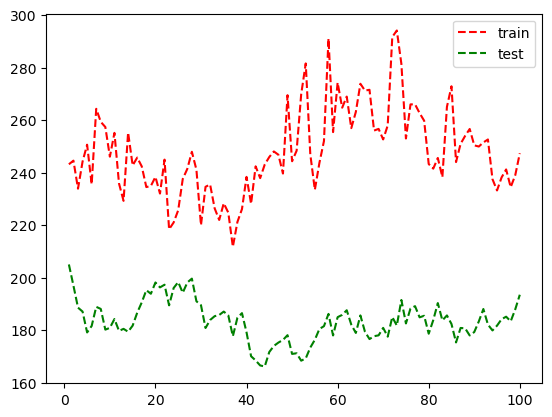

In [ ]:
x=list(range(1,epoches+1))
plt.plot(x, train_loss_history, 'r--', label='train')
plt.plot(x, test_loss_history, 'g--', label='test')
plt.legend()